In [1]:
import numpy as np
import os, torch
from PIL import Image
from tqdm.notebook import tqdm
from multiprocessing import Pool
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import pandas as pd
from methods.low_level_attributes.image_measures import compute_brightness, compute_saturation, compute_warmth, compute_entropy
from datasets.nsd.nsd import NaturalScenesDataset
from datasets.nsd.nsd_clip import NSDCLIPFeaturesDataset
from datasets.nsd.nsd_measures import NSDMeasuresDataset
from methods.high_level_attributes.shift_vectors import order_by_shift_vector
from methods.img_utils import image_grid_as_image
from matplotlib.gridspec import GridSpec

data_dir = 'data/'
output_dir = 'data/part1_1_outputs'

subjects = [1,2,3,4,5,6,7,8]
hemispheres = ['left', 'right']
rois = ['OFA', 'FFA-1', 'FFA-2', 'EBA', 'FBA-1', 'FBA-2', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA-1', 'VWFA-2']

measurements = \
    [f'brightness_{i+1}' for i in range(25)] + \
    [f'saturation_{i+1}' for i in range(25)] + \
    [f'warmth_{i+1}' for i in range(25)] + \
    [f'entropy_{i+1}' for i in range(25)] + \
    [f'depth_{i+1}' for i in range(25)] + \
    [f'gaussian_curvature_{i+1}' for i in range(25)] + \
    [f'surface_normal_1_{i+1}' for i in range(25)] + \
    [f'surface_normal_2_{i+1}' for i in range(25)] + \
    [f'surface_normal_3_{i+1}' for i in range(25)]

missing = [
    (1, 'FFA-2', 'left'),
    (1, 'FBA-2', 'left'),
    (2, 'FBA-1', 'right'),
    (2, 'FBA-1', 'left'),
    (3, 'VWFA-2', 'right'),
    (4, 'VWFA-2', 'right'),
    (4, 'FBA-1', 'left'),
    (7, 'FBA-1', 'left'),
    (7, 'FBA-1', 'right'),
    (8, 'VWFA-2', 'right'),
]

# colors = {
#     'OFA': '#050C9C',
#     'FFA-1': '#3572EF',
#     'FFA-2': '#3ABEF9',
#     'EBA': '#FF3EA5',
#     'FBA-1': '#FF7ED4',
#     'FBA-2': '#FFB5DA',
#     'OPA': '#FF6500',
#     'PPA': '#FF8A08',
#     'RSC': '#FFC100',
#     'OWFA': '#294B29',
#     'VWFA-1': '#50623A',
#     'VWFA-2': '#789461',
# }

colors = {
    'OFA': '#0477BF',
    'FFA-1': '#049DD9',
    'FFA-2': '#79D0F2',

    'EBA': '#D9048E',
    'FBA-1': '#F229AC',
    'FBA-2': '#F279D2',

    'OPA': '#F27405',
    'PPA': '#F2B705',
    'RSC': '#F2E307',

    'OWFA': '#318C07',
    'VWFA-1': '#62BF06',
    'VWFA-2': '#95D904',
}

wordnet_df = pd.read_csv('data/wordnet.csv')
wordnet_scores = pd.read_csv('data/wordnet_scores.csv')
wordnet_vecs = np.load('data/wordnet_vecs.npy')

categories = {
    'faces': 'related to faces, eyes, nose, mouth',
    'hands': 'related to hands, arms, fingers',
    'feet': 'related to feet, legs, toes',
    'people': 'related to people, humans, persons',
    'children': 'related to children, kids, babies',
    'food': 'related to food, meals, eating',
    'dessert': 'related to dessert, sweets, candy',
    'animals': 'related to animals, creatures, fauna',
    'plants': 'related to plants, greenery, flora',
    'water': 'related to water, rivers, lakes, oceans',
    'earth': 'related to soil, rocks, wood',
    'sky': 'related to the sky, clouds',
    'furniture': 'related to furniture, household items',
    'tools': 'related to tools, equipment, instruments',
    'toys': 'related to toys, dolls, playthings',
    'clothing': 'related to clothing, textiles, garments',
    'electronics': 'related to electronics, gadgets, devices',
    'vehicles': 'related to vehicles, transportation, travel',
    'natural outdoors': 'related to natural areas, landscapes, outdoors',
    'manmade outdoors': 'related to urban areas, buildings, structures',
    'manmade indoors': 'related to indoors, rooms, interiors',
    'text': 'related to written text, signs',
}

categories_names = list(categories.keys())

## Gather predictions

### DINO-ViT Predictions

In [2]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_hemispheres, n_rois, n_variations)

def load_subject(subject):

    data = np.empty((2, 12, 50, 2, 12, 11))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):
                for h_i, h in enumerate(hemispheres):
                    for r_i, r in enumerate(rois):
                        if (subject, r, h) in missing:
                            preds = np.nan
                        else:
                            preds = np.load(os.path.join(folder, subfolder, f'dino_vit_preds_{r}_{h}.npy'))
                        data[hemisphere_i, roi_i, subfolder_i, h_i, r_i] = preds

    return data

f = os.path.join(output_dir, 'dino_vit_preds.npy')
if not os.path.exists(f):
    with Pool(8) as p:
        preds_dino = p.map(load_subject, subjects)
    preds_dino = np.stack(preds_dino)
    np.save(f, preds_dino)
else:
    preds_dino = np.load(f).astype(np.float32)
    print(preds_dino.shape)

(8, 2, 12, 50, 2, 12, 11)


### CLIP Predictions

In [3]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_variations)

def load_subject(subject):

    data = np.empty((2, 12, 50, 11))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):

                preds = np.load(os.path.join(folder, subfolder, 'clip_linear_preds.npy'))
                data[hemisphere_i, roi_i, subfolder_i] = preds

    return data

f = os.path.join(output_dir, 'clip_linear_preds.npy')
if not os.path.exists(f):
    with Pool(8) as p:
        preds_clip = p.map(load_subject, subjects)
    preds_clip = np.stack(preds_clip)
    np.save(f, preds_clip)
else:
    preds_clip = np.load(f).astype(np.float32)
    print(preds_clip.shape)

(8, 2, 12, 50, 11)


## Gather properties

### Low-level properties

In [4]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_variations, num_measurements)

def resize(measure):
    measure = torch.from_numpy(measure).float().unsqueeze(0)
    measure = torch.nn.functional.interpolate(
        measure,
        size=(5,5),
        mode="bilinear",
        align_corners=False,
    ).squeeze(0)
    measure = measure.numpy()
    return measure

def load_subject(subject):

    data = np.empty((2, 12, 50, 11, len(measurements)))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):

                img_list = np.array([f for f in os.listdir(os.path.join(folder, subfolder)) if f.endswith('.png')])
                img_list_order = np.argsort([int(f.replace('.png', '')) for f in img_list])
                img_list = [os.path.join(folder, subfolder, f) for f in img_list[img_list_order]]

                for img_i, img_f in enumerate(img_list):

                    ms = []
                    
                    img = Image.open(img_f).convert("RGB")

                    # brightness
                    m = compute_brightness(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # saturation
                    m = compute_saturation(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # warmth
                    m = compute_warmth(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # entropy
                    m = compute_entropy(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # depth
                    m = np.load(img_f.replace('.png', '_depth.npy'))
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # gaussian curvature
                    m = np.load(img_f.replace('.png', '_gaussian_curvature.npy'))
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # surface normal
                    m = np.load(img_f.replace('.png', '_surface_normal.npy'))
                    m_ = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m_)
                    m_ = resize(m)[1].reshape(-1).tolist()
                    ms.extend(m_)
                    m_ = resize(m)[2].reshape(-1).tolist()
                    ms.extend(m_)

                    data[hemisphere_i, roi_i, subfolder_i, img_i] = ms

    return data

f = os.path.join(output_dir, 'measurements.npy')
if not os.path.exists(f):
    with Pool(8) as p:
        measures_array = p.map(load_subject, subjects)
    measures_array = np.stack(measures_array)
    np.save(f, measures_array)
else:
    measures_array = np.load(f).astype(np.float32)
    print(measures_array.shape)

(8, 2, 12, 50, 11, 225)


### CLIP features

In [5]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_variations, 1024)

def load_subject(subject):

    data = np.empty((2, 12, 50, 11, 1024))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):

                feats = np.load(os.path.join(folder, subfolder, 'clip_feats.npy'))
                data[hemisphere_i, roi_i, subfolder_i] = feats

    return data

f = os.path.join(output_dir, 'clip_feats.npy')
if not os.path.exists(f):
    with Pool(8) as p:
        clip = p.map(load_subject, subjects)
    clip = np.stack(clip)
    np.save(f, clip)
else:
    clip = np.load(f).astype(np.float32)
    print(clip.shape)

(8, 2, 12, 50, 11, 1024)


## Plots

### Visualize manipulation

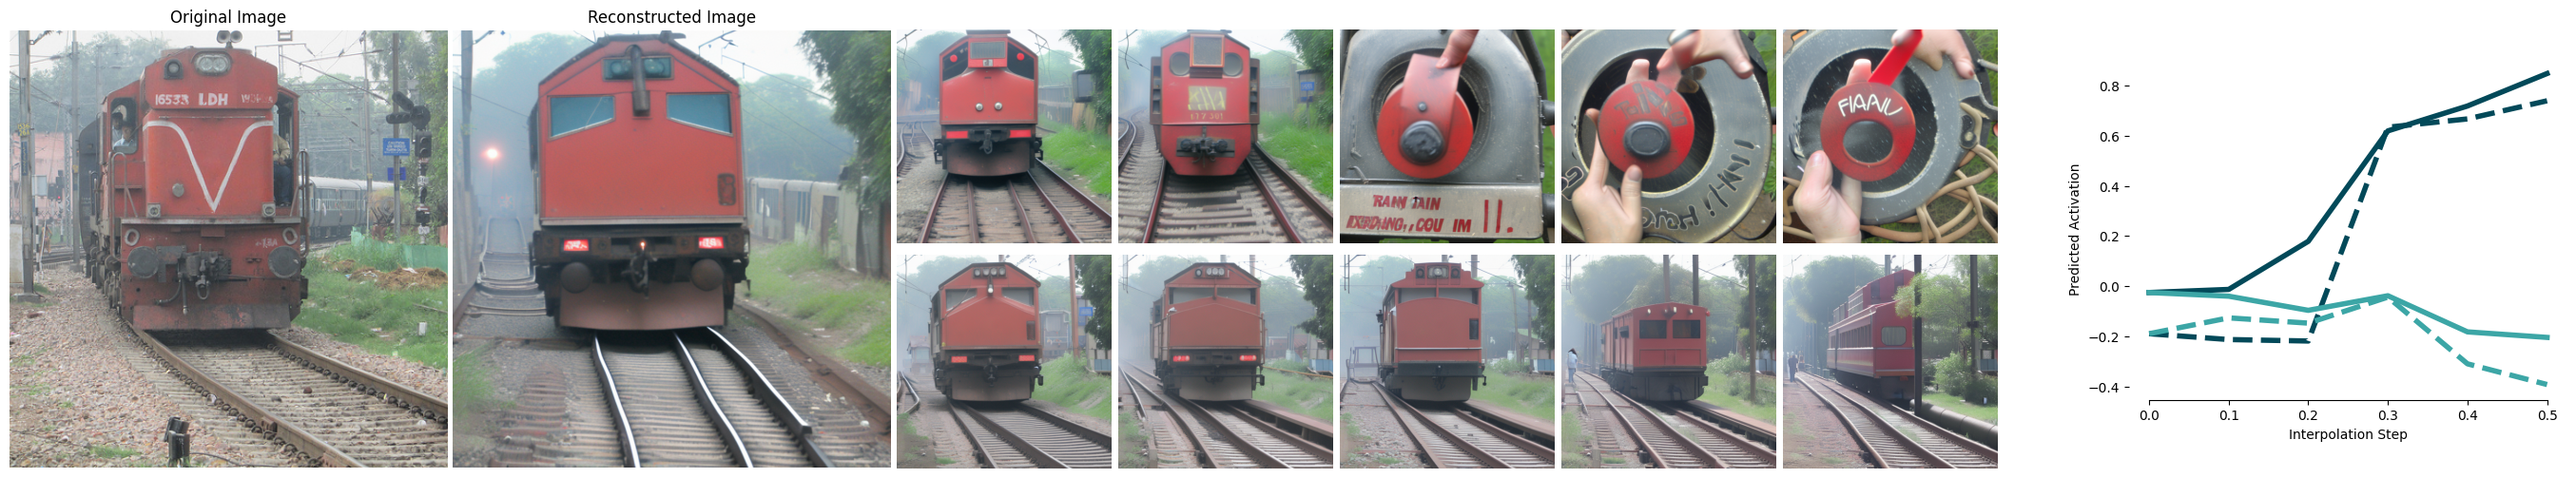

In [6]:
subject = 5
roi = 'VWFA-2'
hemisphere = 'left'

subject_i = subjects.index(subject)
roi_i = rois.index(roi)
hemisphere_i = hemispheres.index(hemisphere)

nsd = NaturalScenesDataset(
    root=os.path.join(data_dir, 'NSD'),
    subject=subject,
    partition="test",
)

idx = np.random.choice(range(50), 1)[0]
x_range = np.linspace(0, 0.5, 6)

folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
subfolder = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])[idx]
orig_img = nsd[int(subfolder)][0]

img_list = np.array([f for f in os.listdir(os.path.join(folder, subfolder)) if f.endswith('.png')])
img_list_order = np.argsort([int(f.replace('.png', '')) for f in img_list])
img_list = [os.path.join(folder, subfolder, f) for f in img_list[img_list_order]]
img_list = [Image.open(f) for f in img_list]

dino_p = preds_dino[subject_i, hemisphere_i, roi_i, idx, hemisphere_i, roi_i]
clip_p = preds_clip[subject_i, hemisphere_i, roi_i, idx]

# ========================================================

size = 3
fig = plt.figure(figsize=(11*size, 2*size), constrained_layout=False)

gs = GridSpec(2, 11, figure=fig, wspace=0.025, hspace=0.05)
ax_orig = plt.subplot(gs.new_subplotspec((0, 0), colspan=2, rowspan=2))
ax_recon = plt.subplot(gs.new_subplotspec((0, 2), colspan=2, rowspan=2))
ax_inc_1 = plt.subplot(gs.new_subplotspec((0, 4)))
ax_inc_2 = plt.subplot(gs.new_subplotspec((0, 5)))
ax_inc_3 = plt.subplot(gs.new_subplotspec((0, 6)))
ax_inc_4 = plt.subplot(gs.new_subplotspec((0, 7)))
ax_inc_5 = plt.subplot(gs.new_subplotspec((0, 8)))
ax_dec_1 = plt.subplot(gs.new_subplotspec((1, 4)))
ax_dec_2 = plt.subplot(gs.new_subplotspec((1, 5)))
ax_dec_3 = plt.subplot(gs.new_subplotspec((1, 6)))
ax_dec_4 = plt.subplot(gs.new_subplotspec((1, 7)))
ax_dec_5 = plt.subplot(gs.new_subplotspec((1, 8)))
ax_plot = plt.subplot(gs.new_subplotspec((0, 9), colspan=2, rowspan=2))

ax_orig.imshow(orig_img)
ax_orig.set_title('Original Image')

ax_recon.imshow(img_list[5])
ax_recon.set_title('Reconstructed Image')

ax_inc_1.imshow(img_list[6])
ax_inc_2.imshow(img_list[7])
ax_inc_3.imshow(img_list[8])
ax_inc_4.imshow(img_list[9])
ax_inc_5.imshow(img_list[10])
ax_dec_1.imshow(img_list[4])
ax_dec_2.imshow(img_list[3])
ax_dec_3.imshow(img_list[2])
ax_dec_4.imshow(img_list[1])
ax_dec_5.imshow(img_list[0])

ax_plot.plot(x_range, clip_p[5:], label='Increase (CLIP)', color='#024959', linewidth=4, zorder=1, linestyle='--')
ax_plot.plot(x_range, dino_p[5:], label='Increase (DINO-ViT)', color='#024959', linewidth=4, zorder=2)
ax_plot.plot(x_range, clip_p[:6][::-1], label='Decrease (CLIP)', color='#3CA6A6', linewidth=4, zorder=1, linestyle='--')
ax_plot.plot(x_range, dino_p[:6][::-1], label='Decrease (DINO-ViT)', color='#3CA6A6', linewidth=4, zorder=2)
ax_plot.spines["right"].set_visible(False)
ax_plot.spines["left"].set_visible(False)
ax_plot.spines["top"].set_visible(False)
ax_plot.yaxis.set_ticks_position("left")
ax_plot.xaxis.set_ticks_position("bottom")
ax_plot.spines["bottom"].set_bounds(min(x_range), max(x_range))
ax_plot.set_ylabel("Predicted Activation")
ax_plot.set_xlabel("Interpolation Step")

bb = ax_plot.get_position()
bb.x0 += 0.04
bb.x1 += 0.04
bb.y0 += 0.12
bb.y1 -= 0.05
ax_plot.set_position(bb)

for ax in [ax_orig, ax_recon, ax_inc_1, ax_inc_2, ax_inc_3, ax_inc_4, ax_inc_5, ax_dec_1, ax_dec_2, ax_dec_3, ax_dec_4, ax_dec_5]:
    ax.axis('off')

plt.show()

### Effect on predicted responses

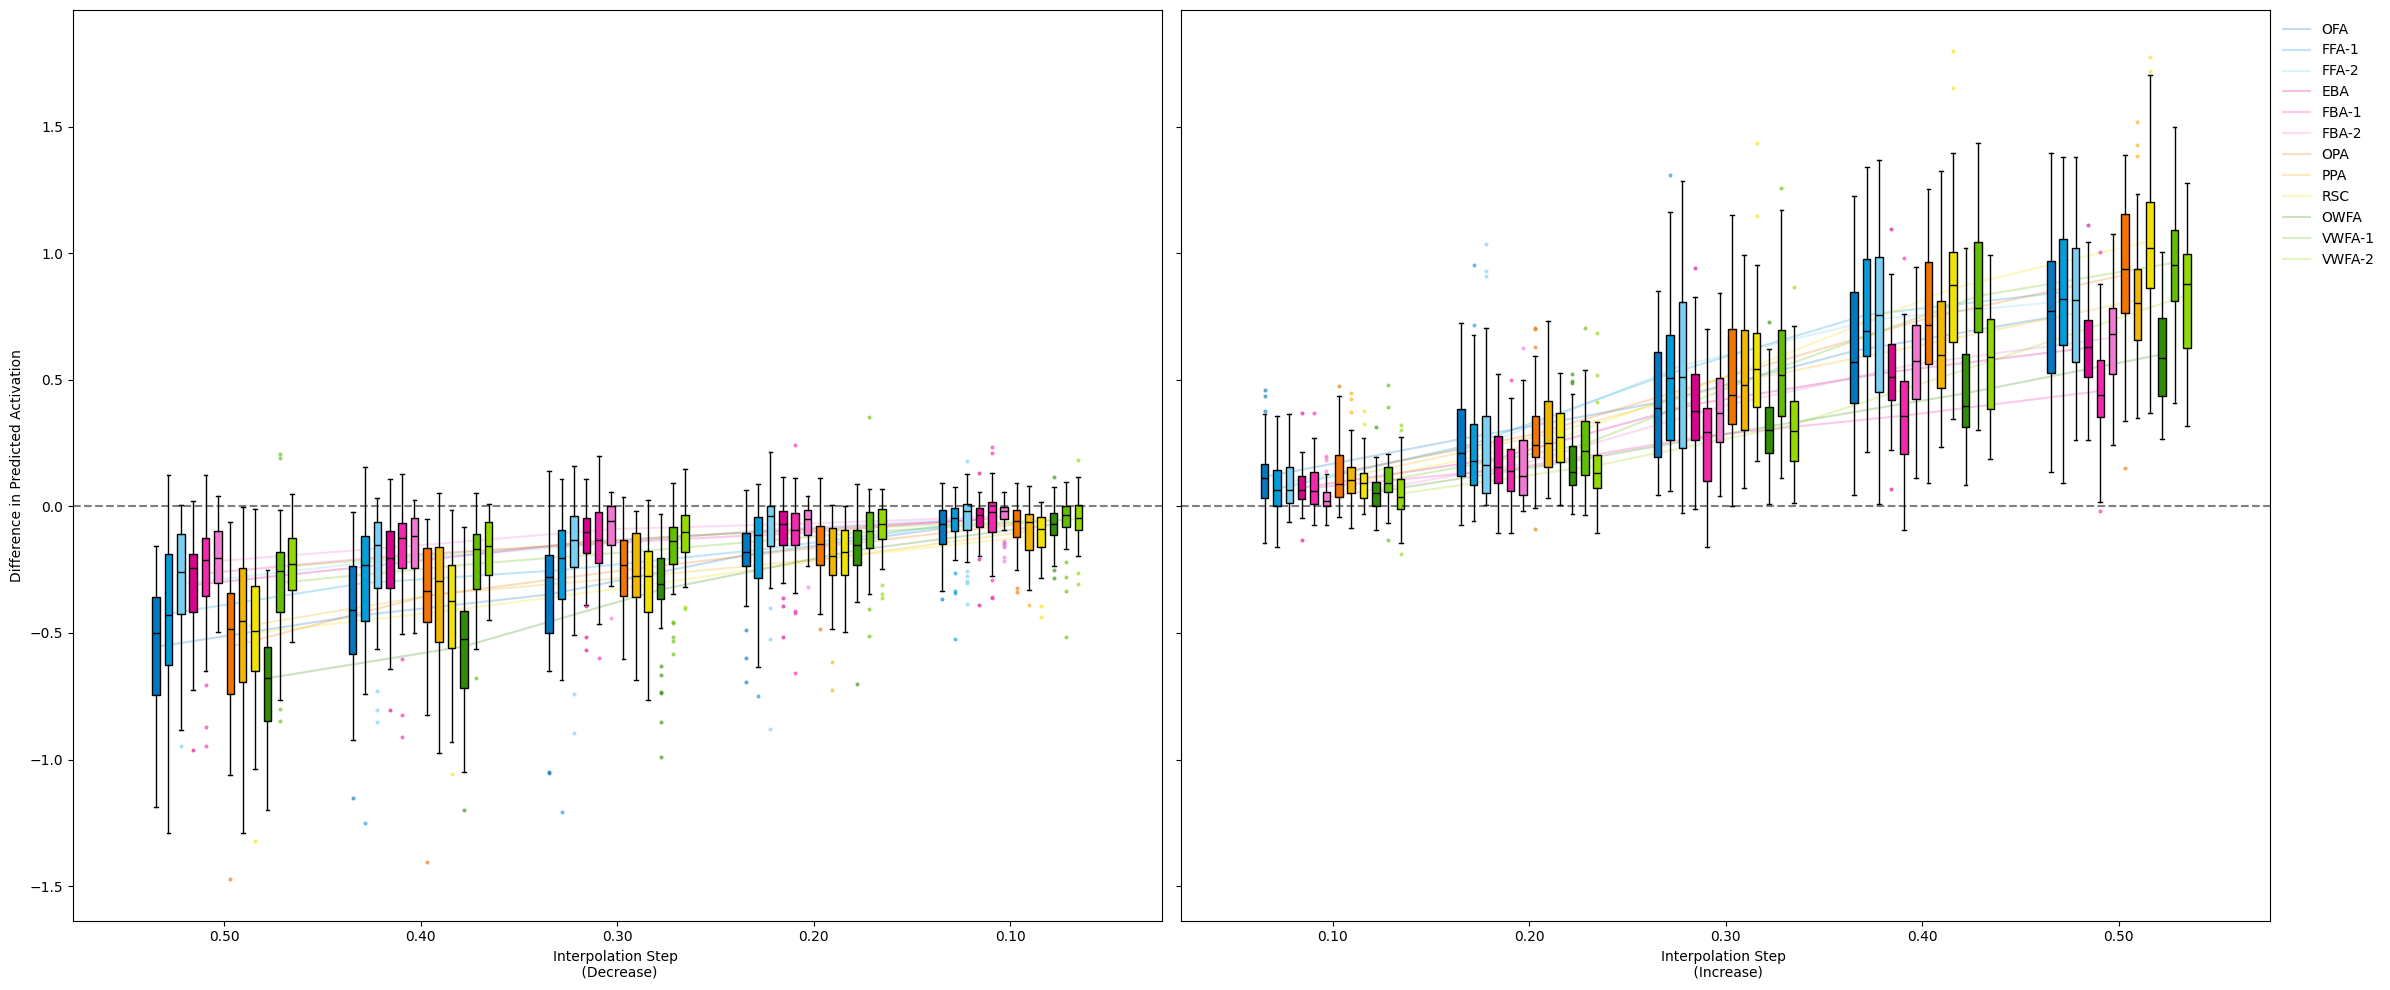

In [7]:
colors = {
    'OFA': '#0477BF',
    'FFA-1': '#049DD9',
    'FFA-2': '#79D0F2',

    'EBA': '#D9048E',
    'FBA-1': '#F229AC',
    'FBA-2': '#F279D2',

    'OPA': '#F27405',
    'PPA': '#F2B705',
    'RSC': '#F2E307',

    'OWFA': '#318C07',
    'VWFA-1': '#62BF06',
    'VWFA-2': '#95D904',
}

subject = 5
hemisphere = 'left'

subject_i = subjects.index(subject)
hemisphere_i = hemispheres.index(hemisphere)

f, axes = plt.subplots(1, 2, figsize=(24, 10), sharey=True)

shifts = np.linspace(-6, 6, 12) * 1.5
alphas = np.linspace(0, 130, 6)[1:]
alphas_rev = -alphas[::-1]
ticks = np.linspace(0, 0.5, 6)[1:]
ticks_rev = ticks[::-1]

for roi_i, roi in enumerate(rois):

    color = colors[roi]
    dino_p = preds_dino[subject_i, hemisphere_i, roi_i, :, hemisphere_i, roi_i]
    dino_p = dino_p - dino_p[:, [5]]

    axes[0].plot(alphas_rev+shifts[roi_i], dino_p.mean(axis=0)[:5], linestyle='solid', label=roi, color=color, alpha=0.25, zorder=0)
    axes[0].boxplot(
        dino_p[:,:5], positions=alphas_rev+shifts[roi_i], widths=1, showfliers=True, patch_artist=True, 
        boxprops=dict(facecolor=color, color='black'), 
        medianprops=dict(color='black'), 
        whiskerprops=dict(color='black'), 
        capprops=dict(color='black'), 
        flierprops=dict(marker='o', markerfacecolor=color, markeredgecolor=color, markersize=2, alpha=0.5), 
    )

    axes[1].plot(alphas+shifts[roi_i], dino_p.mean(axis=0)[6:], linestyle='solid', label=roi, color=color, alpha=0.25, zorder=0)
    axes[1].boxplot(
        dino_p[:,6:], positions=alphas+shifts[roi_i], widths=1, showfliers=True, patch_artist=True, 
        boxprops=dict(facecolor=color, color='black'), 
        medianprops=dict(color='black'), 
        whiskerprops=dict(color='black'), 
        capprops=dict(color='black'), 
        flierprops=dict(marker='o', markerfacecolor=color, markeredgecolor=color, markersize=2, alpha=0.5), 
    )

axes[0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5)

axes[0].set_ylabel('Difference in Predicted Activation')
axes[0].set_xlabel('Interpolation Step \n (Decrease)')
axes[1].set_xlabel('Interpolation Step \n (Increase)')

# axes[0].spines["right"].set_visible(False)
# axes[0].spines["left"].set_visible(False)
# axes[0].spines["top"].set_visible(False)

# axes[1].spines["right"].set_visible(False)
# axes[1].spines["left"].set_visible(False)
# axes[1].spines["top"].set_visible(False)

offset = 20
axes[0].set_xlim(alphas_rev[0] - offset, alphas_rev[-1] + offset)
axes[0].set_xticks(alphas_rev, [f'{a:.2f}' for a in ticks_rev])
axes[1].set_xlim(alphas[0] - offset, alphas[-1] + offset)
axes[1].set_xticks(alphas, [f'{a:.2f}' for a in ticks])

axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
plt.show()

## Categories

### Compute CLIP vectors

In [8]:
vectors = np.empty((len(categories_names), 1024))

for i, category in enumerate(categories_names):

    # Obtain weights for category
    weights = wordnet_scores[categories[category]].values
    # Compute saliency w.r.t. other categories
    all_weights = wordnet_scores[[categories[c] for c in categories_names]].values.sum(-1)
    saliency = weights / all_weights
    weights = weights * saliency

    X = wordnet_vecs
    Y = weights
    lmbda = 100

    W = X.T @ X + lmbda * np.eye(X.shape[1])
    W = (np.linalg.inv(W) @ X.T @ Y).T
    vectors[i] = W

# Replace text vector with precomputed one
text_i = categories_names.index('text')
vectors[text_i] = np.load('data/shift_vectors/dimensions/text/words.npy')

### Compute sims in dataset

In [9]:
subject = 5

dataset = NSDCLIPFeaturesDataset(
    nsd=NaturalScenesDataset(
        root=os.path.join(data_dir, 'NSD'),
        subject=subject,
        partition='train',
    ),
    clip_extractor_type='clip_2_0'
)

sims = 1 - pairwise_distances(dataset.features, vectors, metric='cosine')
sims = np.maximum(sims, 0)

### Visualize categories

In [ ]:
for idx, category in enumerate(categories_names):
    
    order = np.argsort(sims[:, idx])

    max_idx = order[-60:]
    max_imgs = [Image.open(os.path.join(dataset.nsd.root, dataset.nsd.df.iloc[idx]["filename"])) for idx in max_idx]
    max_img = image_grid_as_image(max_imgs, 3, 20)

    plt.figure(figsize=(12,4))
    plt.imshow(max_img)
    plt.axis('off')
    plt.title(categories[category])
    plt.tight_layout()
    plt.show()

### Visualize single image

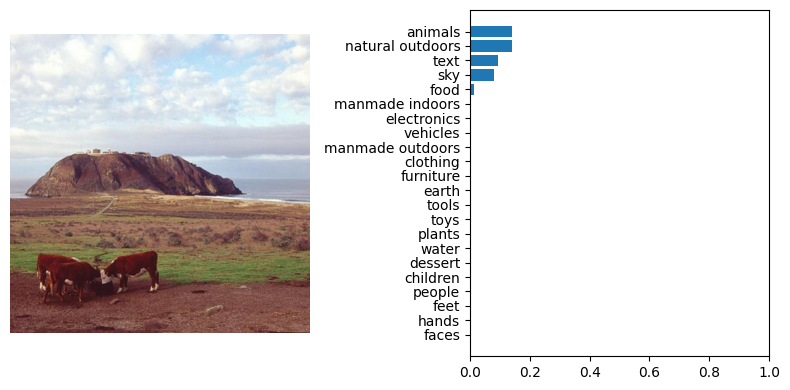

In [22]:
idx = np.random.randint(len(dataset))

sims_image = sims[idx]
order = np.argsort(sims_image)

f, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(dataset.nsd[idx][0])
axes[0].axis('off')
axes[1].barh(np.array(list(categories.keys()))[order], sims_image[order])
axes[1].set_xlim(0,1)
plt.tight_layout()
plt.show()

### Visualize ROI pattern

In [ ]:
subject = 5
hemisphere = 'left'

for roi in rois:

    dataset = NSDCLIPFeaturesDataset(
        nsd=NaturalScenesDataset(
            root=os.path.join(data_dir, 'NSD'),
            subject=subject,
            partition='train',
            roi=roi,
            hemisphere=hemisphere,
            return_average=True
        ),
        clip_extractor_type='clip_2_0'
    )

    endpoints = []
    corrs = []
    for i, category in enumerate(categories_names):
        w = sims[:, i] - sims[:, i].mean()
        order = np.argsort(dataset.nsd.activations.numpy())
        min_idx = order[:25]
        max_idx = order[-25:]
        min_w = w[min_idx].mean()
        max_w = w[max_idx].mean()
        endpoints.append((min_w, max_w))
        corr = np.corrcoef(dataset.nsd.activations.numpy(), w)[0, 1]
        corrs.append(corr)
    maxs = np.array(endpoints)[:, 1]
    mins = np.array(endpoints)[:, 0]
    order = np.argsort(corrs)

    f, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].scatter(maxs[order], np.array(list(categories.keys()))[order], color='black', marker='D')
    axes[0].scatter(mins[order], np.array(list(categories.keys()))[order], color='gray', marker='D')
    cmap = plt.get_cmap('seismic')
    for i, category in enumerate(categories_names):
        color = cmap((corrs[i] + 1) / 2)
        axes[0].plot([mins[i], maxs[i]], [category, category], color=color, zorder=0)
    axes[0].set_xlabel('Weight')
    axes[0].set_title(f'{roi}')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
    plt.colorbar(sm, ax=axes[0], label='Correlation')

    order = np.argsort(dataset.nsd.activations.numpy())
    min_idx = order[:25]
    min_imgs = [dataset.nsd[i][0] for i in min_idx]
    min_img = image_grid_as_image(min_imgs, 5, 5)
    max_idx = order[-25:]
    max_imgs = [dataset.nsd[i][0] for i in max_idx]
    max_img = image_grid_as_image(max_imgs, 5, 5)

    axes[1].imshow(min_img)
    axes[1].axis('off')
    axes[1].set_title('Lowest activations')
    axes[2].imshow(max_img)
    axes[2].axis('off')
    axes[2].set_title('Highest activations')
    plt.tight_layout()
    plt.show()

### Compute weights for manipulations

In [ ]:
hemisphere = 'left'
hemisphere_i = hemispheres.index(hemisphere)

x_range = np.linspace(-0.5, 0.5, 11)

f, axes = plt.subplots(len(rois), len(categories_names), figsize=(len(categories_names)*2, len(rois)*2), sharey=True, sharex=True)

for roi_i, roi in enumerate(rois):

    feats = clip[:, hemisphere_i, roi_i].reshape(-1, 1024)

    clean_idx = ~np.isnan(feats[:,0])
    feats = feats[clean_idx]

    cosines = 1 - pairwise_distances(feats, vectors, metric='cosine')
    cosines = np.maximum(cosines, 0)
    cosines = cosines.reshape(-1, 50, 11, len(categories_names))
    cosines = (cosines - cosines[:, :, [5]]).mean(1)

    for i, category in enumerate(categories_names):
        axes[roi_i,i].plot(x_range, cosines.mean(0)[:, i], color=colors[roi], linewidth=2)
        axes[roi_i,i].fill_between(x_range, cosines.mean(0)[:, i] - cosines.std(0)[:, i], cosines.mean(0)[:, i] + cosines.std(0)[:, i], color=colors[roi], alpha=0.5)
        axes[roi_i,i].set_title(category) if roi_i == 0 else None
        axes[roi_i,i].set_ylabel(f'{roi}\nCosine similarity\ndifference') if i == 0 else None
        axes[roi_i,i].axvline(0, color='gray', linestyle='--', alpha=0.5)
        axes[roi_i,i].axhline(0, color='gray', linestyle='--', alpha=0.5)
        axes[roi_i,i].spines["right"].set_visible(False)
        axes[roi_i,i].spines["left"].set_visible(False)
        axes[roi_i,i].spines["top"].set_visible(False)
        axes[roi_i,i].spines["bottom"].set_visible(False)

plt.tight_layout()
plt.show()

### Correlations (manipulations)

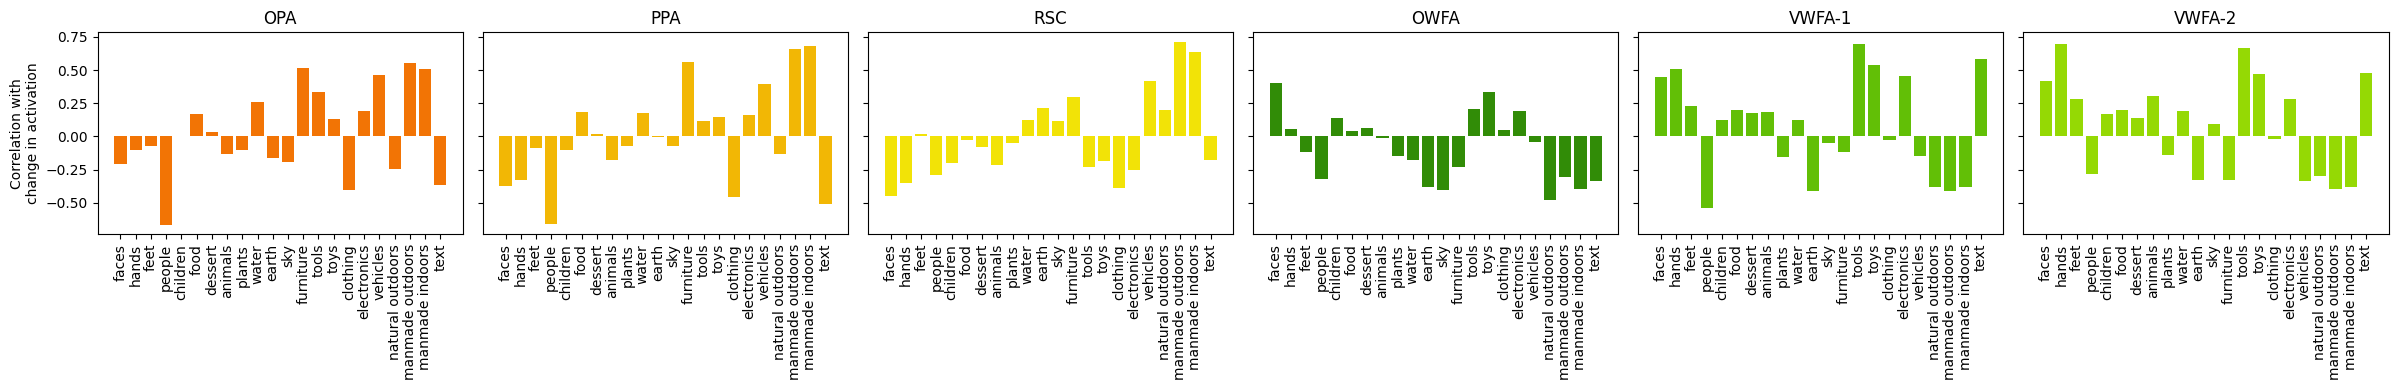

In [55]:
hemisphere = 'left'
hemisphere_i = hemispheres.index(hemisphere)

f, axes = plt.subplots(1, len(rois[6:]), figsize=(4*len(rois[6:]), 4), sharey=True)

for i, roi in enumerate(rois[6:]):

    roi_i = rois.index(roi)

    feats = clip[:, hemisphere_i, roi_i].reshape(-1, 1024)

    clean_idx = ~np.isnan(feats[:,0])
    feats = feats[clean_idx]

    cosines = 1 - pairwise_distances(feats, vectors, metric='cosine')
    cosines = np.maximum(cosines, 0)
    cosines = cosines.reshape(-1, 50, 11, len(categories_names))
    cosines = (cosines - cosines[:, :, [5]])
    cosines = np.delete(cosines, 5, axis=2).reshape(-1, len(categories_names)).T

    preds = preds_dino[:, hemisphere_i, roi_i, :, hemisphere_i, roi_i]
    preds = (preds - preds[:, :, [5]])
    preds = np.delete(preds, 5, axis=2)
    preds = preds.reshape(-1)
    clean_idx = ~np.isnan(preds)
    preds = preds[clean_idx][None]

    corrs = np.corrcoef(preds, cosines)[0, 1:]

    axes[i].bar(categories_names, corrs, color=colors[roi])
    axes[i].set_title(roi)
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)
    axes[i].set_ylabel('Correlation with\nchange in activation') if i == 0 else None

plt.tight_layout()
plt.show()

## Measurements

### Visualize individual image

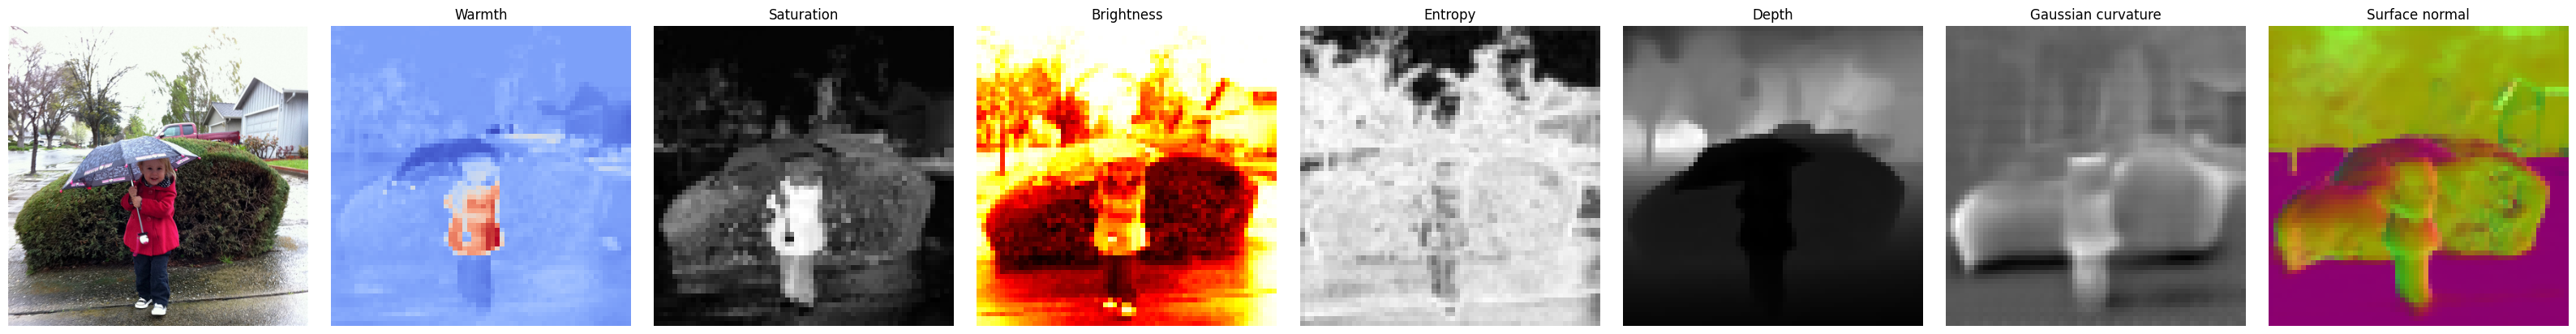

In [6]:
subject = 5
measures = ['warmth', 'saturation', 'brightness', 'entropy', "depth", "gaussian_curvature", "surface_normal"]

dataset = NSDMeasuresDataset(
    nsd=NaturalScenesDataset(
        root=os.path.join(data_dir, 'NSD'),
        subject=subject,
        partition="train",
    ),
    measures=measures,
    patches_shape=(64, 64),
    img_shape=(448,448),
)

idx = np.random.randint(len(dataset))

img, patches = dataset[idx]

f, axes = plt.subplots(1, len(measures)+1, figsize=(4*(len(measures)+1), 4))
axes[0].imshow(img)
axes[0].axis('off')
axes[1].imshow(patches[0], cmap='coolwarm')
axes[1].set_title("Warmth")
axes[1].axis('off')
axes[2].imshow(patches[1], cmap='gray')
axes[2].set_title("Saturation")
axes[2].axis('off')
axes[3].imshow(patches[2], cmap='hot')
axes[3].set_title("Brightness")
axes[3].axis('off')
axes[4].imshow(patches[3], cmap='gray')
axes[4].set_title("Entropy")
axes[4].axis('off')
axes[5].imshow(patches[4], cmap='gray')
axes[5].set_title("Depth")
axes[5].axis('off')
axes[6].imshow(patches[5], cmap='gray')
axes[6].set_title("Gaussian curvature")
axes[6].axis('off')
normals = patches[6:9].permute(1,2,0)
normals = (normals - normals.min()) / (normals.max() - normals.min())
axes[7].imshow(normals)
axes[7].set_title("Surface normal")
axes[7].axis('off')
plt.tight_layout()
plt.show()

### Visualize in dataset

In [ ]:
idxs = np.random.choice(len(dataset), 500, replace=False)

warmths = []
saturations = []
brightnesses = []
entropies = []
depths = []
gaussian_curvatures = []

for idx in tqdm(idxs):
    patches = dataset[idx][1]
    warmths.append(patches[0].mean())
    saturations.append(patches[1].mean())
    brightnesses.append(patches[2].mean())
    entropies.append(patches[3].mean())
    depths.append(patches[4].mean())
    gaussian_curvatures.append(patches[5].mean())

for l in [warmths, saturations, brightnesses, entropies, depths, gaussian_curvatures]:
    
    min_idx = np.argsort(l)[:25]
    min_idx = idxs[min_idx]
    min_imgs = [dataset.nsd[i][0] for i in min_idx]
    max_idx = np.argsort(l)[-25:]
    max_idx = idxs[max_idx]
    max_imgs = [dataset.nsd[i][0] for i in max_idx]
    
    f, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(image_grid_as_image(min_imgs, 5, 5))
    axes[0].axis("off")
    axes[1].imshow(image_grid_as_image(max_imgs, 5, 5))
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

### Change in measurements (manipulation)

In [ ]:
hemisphere = 'left'
hemisphere_i = hemispheres.index(hemisphere)

x_range = np.linspace(-0.5, 0.5, 11)

for m in ['brightness', 'saturation', 'warmth', 'entropy', 'depth']:

    m_idx = [i for i, ms_ in enumerate(measurements) if m in ms_]

    f, axes = plt.subplots(1, len(rois), figsize=(2*len(rois), 3), sharey=True)

    for roi_i, roi in enumerate(rois):

            data = measures_array[:, hemisphere_i, roi_i]
            data = data[:, :, :, m_idx]
            data = (data - data[:, :, [5]]).mean(-1).reshape(-1)
            clean_idx = ~np.isnan(data)
            data = data[clean_idx].reshape(-1, 50, 11).mean(1)

            axes[roi_i].set_ylabel(f'Difference in {m}') if roi_i == 0 else None

            axes[roi_i].axvline(0, color='gray', linestyle='--', alpha=0.5)
            axes[roi_i].axhline(0, color='gray', linestyle='--', alpha=0.5)

            axes[roi_i].plot(x_range, data.mean(0), label=roi, color=colors[roi])
            axes[roi_i].fill_between(x_range, data.mean(0) - data.std(0), data.mean(0) + data.std(0), alpha=0.1, color=colors[roi])
            axes[roi_i].set_title(roi)

    plt.tight_layout()
    plt.show()

### Correlation (avg over image) (manipulation)

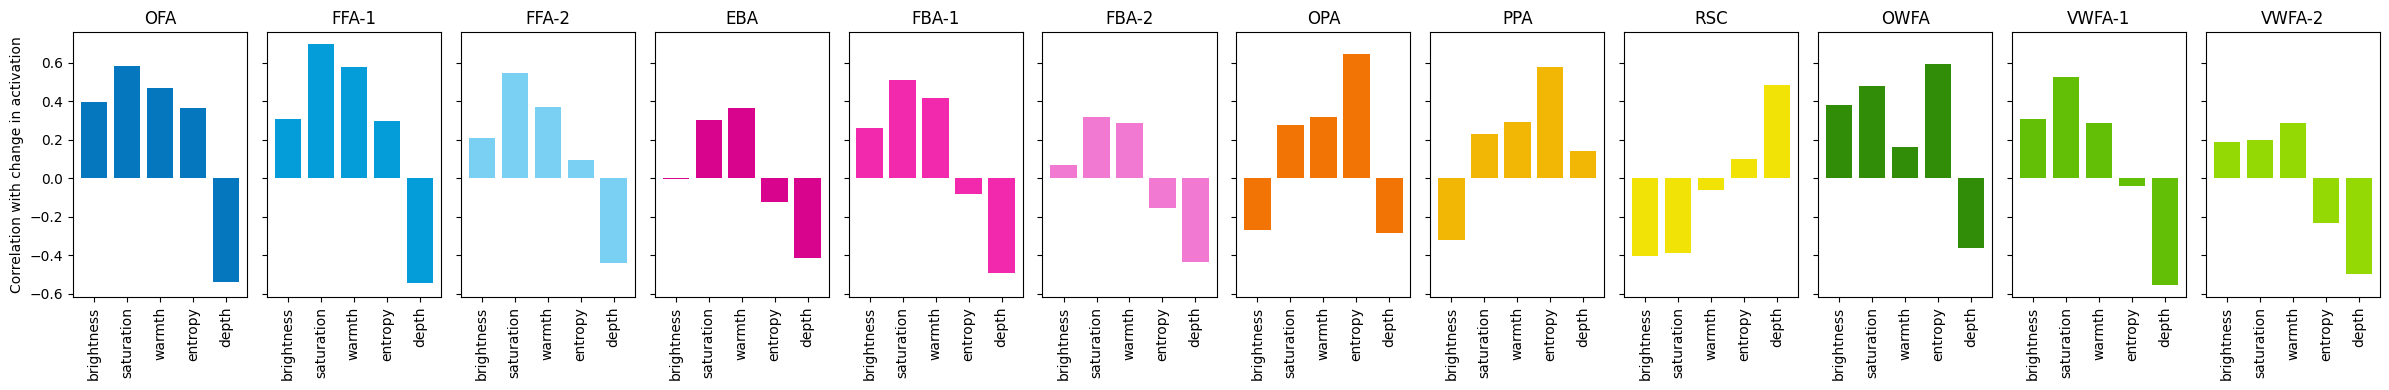

In [76]:
hemisphere = 'left'
hemisphere_i = hemispheres.index(hemisphere)

f, axes = plt.subplots(1, len(rois), figsize=(2*len(rois), 4), sharey=True)

for roi_i, roi in enumerate(rois):

    ms = np.array(['brightness', 'saturation', 'warmth', 'entropy', 'depth'])
    corrs = []

    for m in ms:

        m_idx = [i for i, ms_ in enumerate(measurements) if m in ms_]

        data = measures_array[:, hemisphere_i, roi_i]
        data = data[:, :, :, m_idx].mean(-1)
        data = (data - data[:, :, [5]])
        data = np.delete(data, 5, axis=2)
        data = data.reshape(-1)

        preds = preds_dino[:, hemisphere_i, roi_i, :, hemisphere_i, roi_i]
        preds = (preds - preds[:, :, [5]])
        preds = np.delete(preds, 5, axis=2)
        preds = preds.reshape(-1)

        clean_idx = ~np.isnan(data)

        data = data[clean_idx]
        preds = preds[clean_idx]

        corrcoef = np.corrcoef(preds, data)[0, 1]
        corrs.append(corrcoef)

    corrs = np.array(corrs)

    axes[roi_i].bar(ms, corrs, color=colors[roi])
    axes[roi_i].set_title(roi)
    for tick in axes[roi_i].get_xticklabels():
        tick.set_rotation(90)
    axes[roi_i].set_ylabel('Correlation with change in activation') if roi_i == 0 else None

plt.tight_layout()
plt.show()

### Correlation (per region) (manipulation)

In [ ]:
hemisphere = 'left'

hemisphere_i = hemispheres.index(hemisphere)

for m in ['brightness', 'saturation', 'warmth', 'entropy', 'depth', 'gaussian_curvature', 'surface_normal_1', 'surface_normal_2', 'surface_normal_3']:

    print(m)

    m_idx = [i for i, ms_ in enumerate(measurements) if m in ms_]

    size = 3
    f, axes = plt.subplots(1, len(rois), figsize=(len(rois)*size, size))

    for roi_i, roi in enumerate(rois):

        data = measures_array[:, hemisphere_i, roi_i]
        data = data[:, :, :, m_idx]
        data = (data - data[:, :, [5]])
        data = np.delete(data, 5, axis=2)
        data = data.reshape(-1, 25).T

        preds = preds_dino[:, hemisphere_i, roi_i, :, hemisphere_i, roi_i]
        preds = (preds - preds[:, :, [5]])
        preds = np.delete(preds, 5, axis=2)
        preds = preds.reshape(-1)[None]

        clean_idx = ~np.isnan(preds[0])

        data = data[:, clean_idx]
        preds = preds[:, clean_idx]

        corrs = np.corrcoef(preds, data)[0, 1:]
        corrs = corrs.reshape(5, 5)

        a = axes[roi_i].imshow(corrs, cmap='seismic', vmin=-1, vmax=1)
        axes[roi_i].set_title(f'{roi}')
        axes[roi_i].axis('off')

    plt.tight_layout()
    plt.show()
